In [40]:
# prerequisite
# Milvus=2.4.1  Pymilvus=2.4.1  towhee=1.1.3

from towhee import pipe, ops, DataCollection, AutoPipes
from pymilvus import MilvusClient, DataType, connections, Collection, FieldSchema, CollectionSchema, DataType, AnnSearchRequest, WeightedRanker,utility

# Towhee parameters
MODEL = 'resnet50'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '10.102.9.100'
PORT = '19530'
DIM = 512 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'image_search_multiangle'
INDEX_TYPE = 'AUTOINDEX'
METRIC_TYPE = 'L2'

client = MilvusClient("http://10.102.9.100:19530")

2024-05-16 19:53:56,905 - 7986699328 - milvus_client.py-milvus_client:641 - DEBUG: Created new connection using: 741864c664cc426f8451ef0f409d852c


In [41]:
# create by pymilvus ORM

def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding1', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim),
        FieldSchema(name='embedding2', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors1', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search2')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE
    }
    collection.create_index(field_name='embedding1', index_params=index_params)
    collection.create_index(field_name='embedding2', index_params=index_params)
    return collection


# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

A new collection created: image_search_multiangle


In [42]:
# create with milvus client

client.drop_collection(collection_name=COLLECTION_NAME)

schema = MilvusClient.create_schema(
    auto_id=False,
    enable_dynamic_field=False,
)

# 2. Add fields to schema
schema.add_field(field_name="path1", datatype=DataType.VARCHAR, description='path to image', max_length=500, is_primary=True)
schema.add_field(field_name="path2", datatype=DataType.VARCHAR, description='path to image', max_length=500)
schema.add_field(field_name="embedding1", datatype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=512)
schema.add_field(field_name="embedding2", datatype=DataType.FLOAT_VECTOR, description='image embedding vectors2', dim=512)

index_params = client.prepare_index_params()

index_params.add_index(
    field_name= "embedding1",
    index_type= "AUTOINDEX",
    metric_type = "L2"
)

index_params.add_index(
    field_name= "embedding2",
    index_type= "AUTOINDEX",
    metric_type = "L2"
)

client.create_collection(collection_name=COLLECTION_NAME, schema=schema, index_params=index_params)

2024-05-16 19:53:58,141 - 7986699328 - milvus_client.py-milvus_client:608 - DEBUG: Successfully created collection: image_search_multiangle
2024-05-16 19:53:58,701 - 7986699328 - milvus_client.py-milvus_client:167 - DEBUG: Successfully created an index on collection: image_search_multiangle
2024-05-16 19:53:59,254 - 7986699328 - milvus_client.py-milvus_client:167 - DEBUG: Successfully created an index on collection: image_search_multiangle


In [43]:
import os

QUERY_SRC = 'photos/test-img'
entities = []

image_pipe = AutoPipes.pipeline('text_image_embedding')

for root, _, dirs in os.walk(QUERY_SRC):
    img_list = []
    for dir in dirs:
        if dir.startswith('.'):  # 遇到以 . 开头的文件夹，跳过该循环
            continue
        # 构建子目录路径
        sub_dir = os.path.join(root, dir)
        sub_dir = sub_dir.replace('\\', '/')
        img_list.append(sub_dir)
    
    if len(img_list) > 0:
        print(img_list[1])
        print(img_list[0])
        print("---------------------------------------")
    
        # generate image embedding
        
        embedding = image_pipe(img_list[1]).get()[0]
        embedding1 = image_pipe(img_list[0]).get()[0]

        # creat a dictionary for each entity
        entity = {
            "path1": img_list[1],
            "path2": img_list[0],
            "embedding1": embedding,
            "embedding2": embedding1
        }

        # add the entity to the list
        entities.append(entity)
    
client.insert(collection_name=COLLECTION_NAME, data=entities)


2024-05-16 19:54:01,652 - 7986699328 - clip.py-clip:100 - WARNING: Gpu not available, use cpu


photos/test-img/9/1.jpg
photos/test-img/9/2.jpg
---------------------------------------
photos/test-img/7/1.jpg
photos/test-img/7/2.jpg
---------------------------------------
photos/test-img/6/1.jpg
photos/test-img/6/2.jpg
---------------------------------------
photos/test-img/1/1.jpg
photos/test-img/1/2.jpg
---------------------------------------
photos/test-img/10/1.jpg
photos/test-img/10/2.jpg
---------------------------------------
photos/test-img/8/1.jpg
photos/test-img/8/2.jpg
---------------------------------------
photos/test-img/4/1.jpg
photos/test-img/4/2.jpg
---------------------------------------
photos/test-img/3/1.jpg
photos/test-img/3/2.jpg
---------------------------------------
photos/test-img/2/1.jpg
photos/test-img/2/2.jpg
---------------------------------------
photos/test-img/5/1.jpg
photos/test-img/5/2.jpg
---------------------------------------


{'insert_count': 10,
 'ids': ['photos/test-img/9/1.jpg', 'photos/test-img/7/1.jpg', 'photos/test-img/6/1.jpg', 'photos/test-img/1/1.jpg', 'photos/test-img/10/1.jpg', 'photos/test-img/8/1.jpg', 'photos/test-img/4/1.jpg', 'photos/test-img/3/1.jpg', 'photos/test-img/2/1.jpg', 'photos/test-img/5/1.jpg']}

In [44]:
COLLECTION_NAME = "image_search_multiangle"
client.load_collection(collection_name=COLLECTION_NAME)
# client.describe_collection(collection_name=COLLECTION_NAME)
# client.get_collection_stats(collection_name=COLLECTION_NAME)
client.query(collection_name=COLLECTION_NAME,output_fields=["count(*)"])
#Collection.num_entities(collection)

[{'count(*)': 0}]

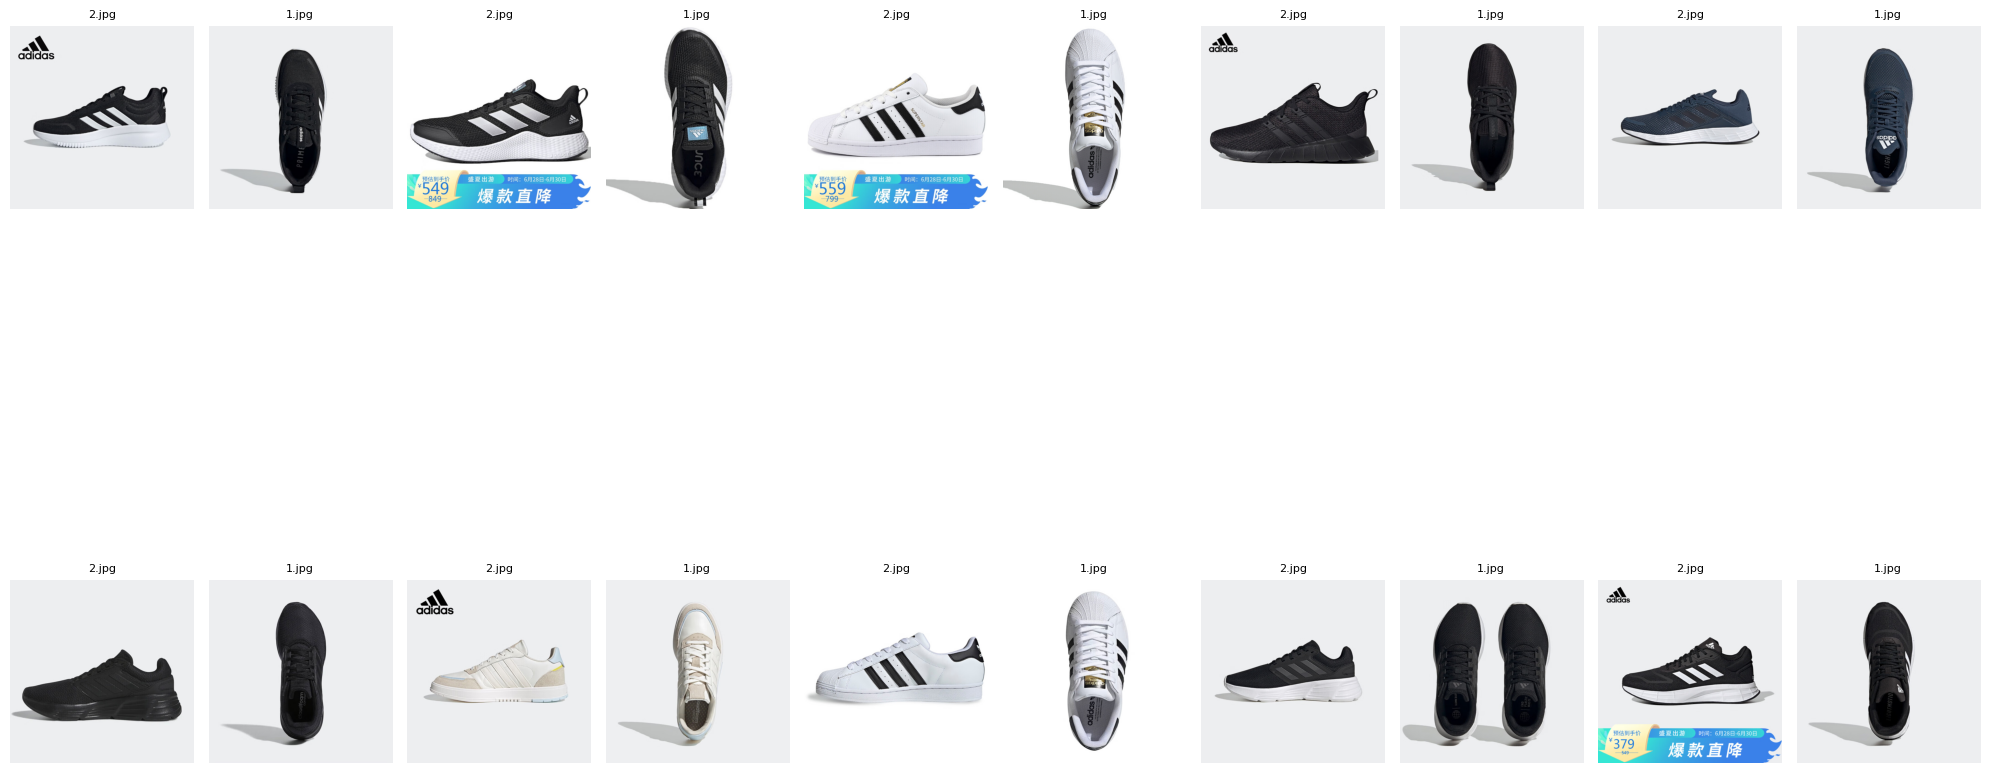

In [49]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def get_image_paths(folder):
    image_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.png', '.bmp')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
    return image_paths

folder_path = 'photos/test-img'
image_paths = get_image_paths(folder_path)
num_images = len(image_paths)
ncols = 10  # 每行显示4张图片
nrows = (num_images + ncols - 1) // ncols  # 计算需要的行数
fig = plt.figure(figsize=(20, 15))  # 设置整体图像大小

for i, image_path in enumerate(image_paths):
    ax = fig.add_subplot(nrows, ncols, i+1)  # 创建子图
    img = mpimg.imread(image_path)  # 读取图片
    ax.imshow(img)  # 显示图片
    ax.axis('off')  # 不显示坐标轴
    ax.set_title(os.path.basename(image_path), fontsize=8)  # 设置子图标题为文件名

plt.tight_layout()  # 自动调整子图参数
plt.show()

["['id: photos/test-img/3/1.jpg, distance: 0.0, entity: {}', 'id: photos/test-img/9/1.jpg, distance: 0.2512781620025635, entity: {}', 'id: photos/test-img/2/1.jpg, distance: 0.29915493726730347, entity: {}', 'id: photos/test-img/4/1.jpg, distance: 0.3077608644962311, entity: {}', 'id: photos/test-img/6/1.jpg, distance: 0.33239614963531494, entity: {}']"]


img,prev
,

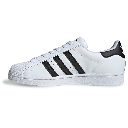
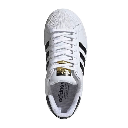
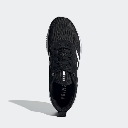
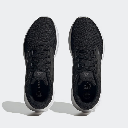
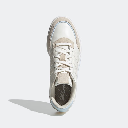
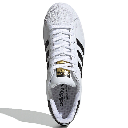

In [46]:
def read_images(img_paths):
    imgs = []
    op = ops.image_decode.cv2_rgb()
    for p in img_paths[0]:
        p_list = str(p).split(',')
        path =p_list[0][4:]
        imgs.append(op(path))
        
    return imgs


def SearchPath(connection,vector):
    # Single vector search
    res = connection.search(
        # Replace with your query vector
        data=vector,
        limit=5, # Max. number of search results to return
        anns_field='embedding2',
        param={"metric_type": "L2", "params": {}} # Search parameters
    )
    # request = AnnSearchRequest(**search_param_2)
    print(res)
    return res
    
def ImageSearch(connection,path):    
    emb = image_pipe(path).get()
    res = SearchPath(connection,emb)
    p = (
        pipe.input('path','search_result')
        .map('path', 'img', ops.image_decode.cv2('rgb'))
        .map('search_result','prev',read_images)
        .output('img','prev')
    )
    DataCollection(p(path,res)).show()

# connection = connections.connect(host=HOST, port=PORT)
ImageSearch(collection,"photos/test-img/3/2.jpg")

["['id: photos/test-img/3/1.jpg, distance: 1.8905282020568848, entity: {}', 'id: photos/test-img/6/1.jpg, distance: 1.6280992031097412, entity: {}', 'id: photos/test-img/4/1.jpg, distance: 1.6080491542816162, entity: {}', 'id: photos/test-img/9/1.jpg, distance: 1.590337872505188, entity: {}', 'id: photos/test-img/2/1.jpg, distance: 1.5609498023986816, entity: {}']"]


img,prev
,

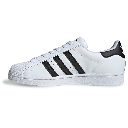
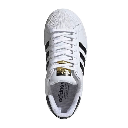
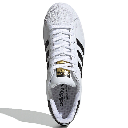
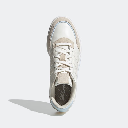
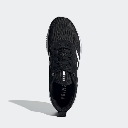
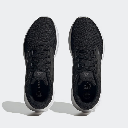

In [47]:
def read_images(img_paths):
    imgs = []
    print(img_paths)
    op = ops.image_decode.cv2_rgb()
    for p in img_paths[0]:
        p_list = str(p).split(',')
        path =p_list[0][4:]
        imgs.append(op(path))
        
    return imgs

def get_image_pipe(path1,path2):
    emb1 = image_pipe(path1).get()
    search_param_1 = {
        "data": emb1, # Query vector
        "anns_field": "embedding1", # Vector field name
        "param": {
            "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
            "params": {"nprobe": 10}
        },
        "limit": 10 # Number of search results to return in this AnnSearchRequest
    }
    request_1 = AnnSearchRequest(**search_param_1)

    emb2 = image_pipe(path2).get()
    search_param_2 = {
        "data": emb2, # Query vector
        "anns_field": "embedding2", # Vector field name
        "param": {
            "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
            "params": {"nprobe": 10}
        },
        "limit":10 # Number of search results to return in this AnnSearchRequest
    }
    request_2 = AnnSearchRequest(**search_param_2)

    reqs = [request_1, request_2]

    rerank = WeightedRanker(1, 1)  

    res = collection.hybrid_search(
        reqs, # List of AnnSearchRequests created in step 1
        rerank, # Reranking strategy specified in step 2
        limit=5 # Number of final search results to return
    )
    return res

def ImageSearch(path1,path2):    
    res = get_image_pipe(path1,path2)
    p = (
        pipe.input('path','search_result')
        .map('path', 'img', ops.image_decode.cv2('rgb'))
        .map('search_result','prev',read_images)
        .output('img','prev')
    )
    DataCollection(p(path1,res)).show()

ImageSearch("photos/test-img/3/2.jpg","photos/test-img/3/2.jpg")